In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Disclaimer**

Step 1 and 2 are taken from the notebook 6 from the Machine Learning materials and were slightly modified.

# MNIST Dataset

This notebook demonstrates the usage of the Neural Network Framework with the example of the MNIST dataset.
From the [creator's homepage](http://yann.lecun.com/exdb/mnist/):
> The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples.

# 1. Load Data

## 1.1 Install missing packages
Make sure you have installed all packages. This module uses three packages ("mnist", "seaborn" and "tqdm"). They should be present
in this projects Pipfile, so if you use pipenv, you can simply remove the comment in the following cell, execute it and you should be good to go:

In [10]:
#!pipenv install

If you don't use pipenv, run `pip install seaborn python-mnist tqdm`.

## 1.2 Download MNIST data
The data can be loaded using the `mnist` module and the mnist_downloader.py file:

In [11]:
import mnist_downloader

# make sure that you don't accidently add the download folder
# to your git (it *should* already be in the .gitignore)
download_folder = "./mnist/"
mnist_downloader.download_and_unzip(download_folder)

mnist/train-images-idx3-ubyte.gz already exists, skipping ...
mnist/train-images-idx3-ubyte already exists, skipping ... 
mnist/train-labels-idx1-ubyte.gz already exists, skipping ...
mnist/train-labels-idx1-ubyte already exists, skipping ... 
mnist/t10k-images-idx3-ubyte.gz already exists, skipping ...
mnist/t10k-images-idx3-ubyte already exists, skipping ... 
mnist/t10k-labels-idx1-ubyte.gz already exists, skipping ...
mnist/t10k-labels-idx1-ubyte already exists, skipping ... 


In [12]:
from mnist import MNIST

mndata = MNIST('mnist', return_type="numpy")

images_train, labels_train = mndata.load_training()
images_validation, labels_validation = mndata.load_testing()

# 2. Exploration

* the dataset contains 10 **classes** (0, 1, 2,... 9)
* each image, or **sample**, is **labeled** with one of these classes
* each image consists of 28x28 pixels, or 784 **features**

Reshape the training image to an matrix of the size 28x28.
Then visualize it using Matplotlib:


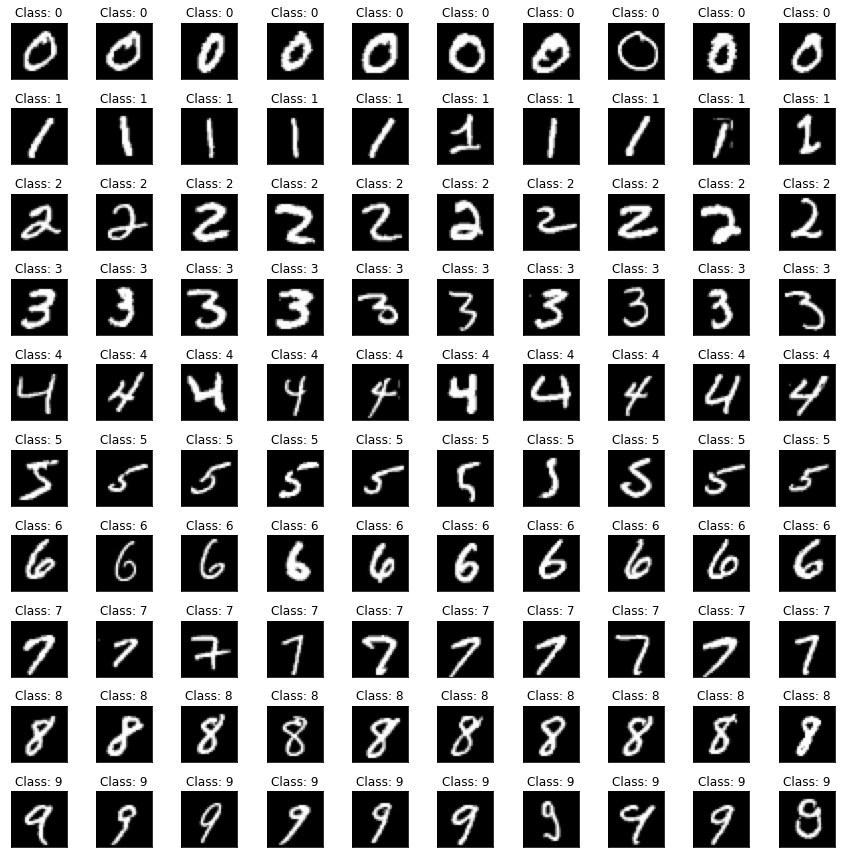

In [13]:
fig, axes = plt.subplots(10, 10, figsize=(12, 12))

for target_class in range(0, 10):
    # this is the important part: we select all samples
    # that belong to the current class
    target_sample_selection = labels_train == target_class
    class_images = images_train[target_sample_selection][:10]

    for col_idx in range(10):
        row_idx = target_class
        flat_image = class_images[col_idx]
        axes[row_idx, col_idx].imshow(flat_image.reshape(28, 28), cmap="gray")

        # hide the ticks
        axes[row_idx, col_idx].set_xticks([])
        axes[row_idx, col_idx].set_yticks([])

        # put the label above each image
        axes[row_idx, col_idx].set_title(f"Class: {target_class}")
fig.tight_layout(pad=1)

# 3. The Neural Network
## 3.1 Create a new instance of the Neural Network

For creating the Neural Network you need to decide on following parameters:
* architecture: how many hidden layers, how many nodes per hidden layer
* activation function: which function is used to activate the output of a layer node, you can choose between
'sigmoid', 'tanh', and 'relu'
* scaler: choose between 'standard' (Standard Scaler, the default) and 'normal' (Normal Scaler)

In [14]:
from netneural.network.nn import NeuralNetwork

input_layer = 784  # this means the input layer has 784 nodes, this is needed for our 28x28=784 input values
output_layer = 10  # since we want to classify 10 classes (0,1,...,9)
layers = (input_layer, 20, 20, output_layer) # we chose two hidden layers with each 20 nodes

nn = NeuralNetwork(layers_nn=layers, activation_function='sigmoid')  # the weights will be initialized randomly if no weights are provided

Neural Network created


Or you can provide a list of numpy arrays for initializing weights:

In [15]:
weights = [np.random.rand(784, 20), np.random.rand(20,20), np.random.rand(20,10)]
nn_with_weights = NeuralNetwork(layers_nn=layers, activation_function='sigmoid', weight_matrices=weights)

Neural Network created


## 3.2 Training the Neural Network

Before training, if you want to scale the data, you can do that using the Standard or Normal Scaler, the default for a Neural
Network object is the Standard Scaler:

In [16]:
nn.scaler.fit(images_train)  # first fit the training data to the scaler
images_train_scaled = nn.scaler.transform(images_train)  # then transform using fitted scaler
images_validation_scaled = nn.scaler.transform(images_validation)  # don't forget to also scale the test data
print(f'Mean of each feature before standardization: {images_train.mean(axis=0).mean()}')
print(f'Mean of each feature after standardization: {images_train_scaled.mean(axis=0).mean().round()}')

Mean of each feature before standardization: 33.318421449829934
Mean of each feature after standardization: -0.0


For training the Neural Network, you need to specify following parameters:
* training data: the training data on which the network should be trained on
* iterations: the number of epochs that the network should be trained for
* learning rate: the alpha used for training
* test data (optional): test data to perform evaluations on during the training process
* optimizer (optional): the default is gradient descent, you can also choose the Adam Optimizer
* batch size (optional): you can set the size of a batch for batch training the neural network, if none is set the whole
training data will be used in one iteration at once, otherwise the training data will be seperated into batches of size
`batch_size` and then the network will train separately on each batch per iteration, the batches will be randomized each
iteration
* encode: you will need to specify if your target values need to be encoded (they do need to be encoded if you are training for multiclass classification and did not hand over an encoder when creating the network)

In [17]:
f1_history, acc_history, err_history = nn.train(images_train_scaled, labels_train, iterations=10,
                                                learning_rate=0.001, optimizer='adam',
                                                test_data=images_validation_scaled, test_target=labels_validation,
                                                batch_size=500, encode=True)

Training the Network
Using Adam Optimizer 
Batchsize: 500


100%|██████████| 10/10 [00:16<00:00,  1.64s/it, F1 Test=0.871, F1 Training=0.874]

Training of the Neural Network Done
F1 Score (Training Set): 0.8737
F1 Score (Test Set): 0.8712


## 3.3 Evaluating the Neural Network
After the training, the F1 score history and other values can be plotted to evaluate the model further:

/Users/felixachter/source/personal-github/neural-network-framework/netneural/network/plot_lib.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


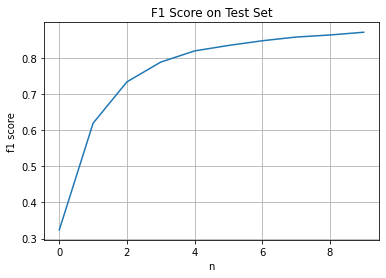

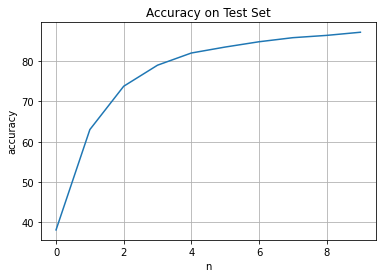

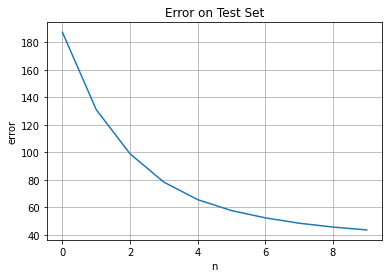

In [18]:
from netneural.network.plot_lib import plot_line

plot_line(f1_history, 'n', 'f1 score', 'F1 Score on Test Set')
plot_line(acc_history, 'n', 'accuracy', 'Accuracy on Test Set')
plot_line(err_history, 'n', 'error', 'Error on Test Set')

You can also plot a confusion matrix, the diagonal should be more highlighted than the rest, since that means that the predictions were mostly correct:

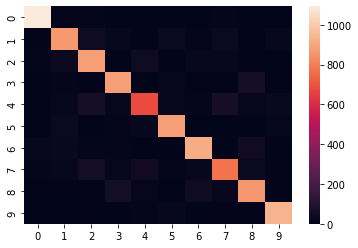

In [19]:
import seaborn as sns

predictions = nn.predict(images_validation_scaled)
confusion_matrix = np.zeros((10, 10))
for i in range(len(predictions)):
    confusion_matrix[labels_validation[i] - 1][predictions[i] - 1] += 1
sns.heatmap(confusion_matrix)
plt.show()

## 3.4 Use Neural Network for Predictions

First, let's take one handwritten number and visualize it:

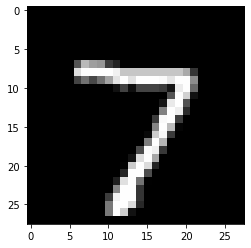

In [20]:
flattened_image = images_validation[0] # take first test image
image = flattened_image.reshape(28, 28)
plt.imshow(image, cmap="gray")

Then, let's see what the trained model classifies the image as:

In [21]:
prediction = nn.predict(images_validation_scaled[0])
if prediction == labels_validation[0]:
    print(f'Yay, the Neural Network correctly identified number {prediction}!')
else:
    print(f'Oh no, the Neural Network thought that the {labels_validation[0]} is a {prediction}. We will need better training!')

Yay, the Neural Network correctly identified number 7!


## 4. Additional Features
You can also perform Principal Component Analysis (PCA) on the data, if you want to reduce the dimension of the input
features:

In [22]:
from netneural.pca.pca import PCA

pca = PCA()
images_train_scaled_pca = pca.pca(images_train_scaled, var_per=0.999)  # use the variance percentage you want to cover as parameter
images_validation_scaled_pca = pca.transform_data(images_validation_scaled)  # don't forget test data
print(f'PCA reduced attribute count from {images_train_scaled.shape[1]} to {images_train_scaled_pca.shape[1]}')

PCA reduced attribute count from 784 to 679


In [23]:
# you could also directly define the desired feature count with the `number_pcs` attribute
pca_2 = PCA()  # be careful to use separate pca object to not mess with previous one
images_train_scaled_pca_2 = pca_2.pca(images_train_scaled, number_pcs=600)  
print(f'PCA reduced attribute count from {images_train_scaled.shape[1]} to {images_train_scaled_pca_2.shape[1]}')

PCA reduced attribute count from 784 to 600


In [24]:
input_features = images_train_scaled_pca.shape[1]
shape = (input_features, 20, 20, output_layer)
nn_pca = NeuralNetwork(shape, activation_function='sigmoid', scaler='standard')

Neural Network created


In [25]:
# train the new model
f1_history_pca, acc_history_pca, error_history_pca = nn_pca.train(images_train_scaled_pca, labels_train, 10, 0.01, 
                                                                  500, images_validation_scaled_pca, labels_validation,
                                                               optimizer='adam', encode=True)

Training the Network
Using Adam Optimizer 
Batchsize: 500


100%|██████████| 10/10 [00:25<00:00,  2.57s/it, F1 Test=0.921, F1 Training=0.955]

Training of the Neural Network Done
F1 Score (Training Set): 0.9554
F1 Score (Test Set): 0.9206000000000001


Now, we have two models, ´nn´ and ´nn_pca´. We can compare how good they learned by plotting their F1 Score history:

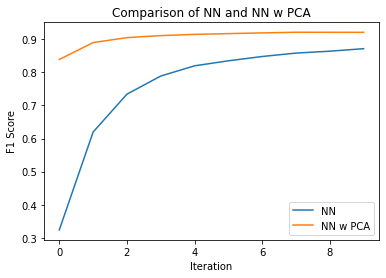

In [26]:
plt.plot(range(10), f1_history, label = "NN")
plt.plot(range(10), f1_history_pca, label = "NN w PCA")
plt.xlabel('Iteration')
plt.ylabel('F1 Score')
plt.title('Comparison of NN and NN w PCA')
plt.legend()

## 5. Saving and Loading

Now that we have trained an awesome model, we want to store it for later use. This can be done using the `save_session`
function provided in the [nn.session_util.py](/nn_session_util.py) file. It stores the model as a compressed .pkl file
and prints the name it used for storing.

In [27]:
from netneural.session.nn_session_util import save_session
import os

folder = os.path.abspath("./")
save_session(nn, nn.encoder.unique_labels, pca, f1_history[-1], folder=folder)

Session Configuration stored in file /Users/felixachter/source/personal-github/neural-network-framework/example_usage/config_87_f1_2022-04-11 18-12-26.pkl


With the name of the file, we can now load our neural network again.

In [28]:
from netneural.session.nn_session_util import load_from_config

file_name = './config_87_f1_2022-04-08 13-41-24.pkl'  # here put your file's name
nn, pca = load_from_config(file_name)

Neural Network created
